# **Waze Project**


Previously, we completed a project proposal, and used Python to explore and analyze Waze’s user data, create data visualizations, and conduct a hypothesis test. Most recently, we built a binomial logistic regression model based on multiple variables.

Now, Leadership want my team to build a machine learning model to predict user churn. To get the best results, my team decides to build and test two tree-based models: random forest and XGBoost.

Our work will help leadership make informed business decisions to prevent user churn, improve user retention, and grow Waze’s business.


# **Build a machine learning model**

In this activity, we will practice using tree-based modeling techniques to predict on a binary target class.
<br/>

**The purpose** of this model is to find factors that drive user churn.

**The goal** of this model is to predict whether or not a Waze user is retained or churned.
<br/>

*This activity has three parts:*

**Part 1:** Ethical considerations
* Consider the ethical implications of the request

* Should the objective of the model be adjusted?

**Part 2:** Feature engineering

* Perform feature selection, extraction, and transformation to prepare the data for modeling

**Part 3:** Modeling

* Build the models, evaluate them, and advise on next steps


# **Build a machine learning model**

<img src="images/Pace.png" width="100" height="100" align=left>

# **PACE stages**





Throughout these project notebooks, we'll see references to the problem-solving framework PACE. The following notebook components are labeled with the respective PACE stage: Plan, Analyze, Construct, and Execute.

<img src="images/Plan.png" width="100" height="100" align=left>


## **PACE: Plan**


In this stage, considering the following questions:

1.   What are we being asked to do?
> _Predict if a customer will churn or be retained._

2.   What are the ethical implications of the model? What are the consequences of your model making errors?
  *   What is the likely effect of the model when it predicts a false negative (i.e., when the model says a Waze user won't churn, but they actually will)?
  > _Waze will fail to take proactive measures to retain users who are likely to stop using the app. For example, Waze might proactively push an app notification to users, or send a survey to better understand user dissatisfaction._
  *   What is the likely effect of the model when it predicts a false positive (i.e., when the model says a Waze user will churn, but they actually won't)?
  > _Waze may take proactive measures to retain users who are NOT likely to churn. This may lead to an annoying or negative experience for loyal users of the app._
3.   Do the benefits of such a model outweigh the potential problems?
  > _The proactive measueres taken by Waze might have unintended effects on users, and these effects might encourage user churn. Follow-up analysis on the effectiveness of the measures is recommended. If the measures are reasonable and effective, then the benefits will most likely outweigh the problems._
4.   Would we proceed with the request to build this model? Why or why not?

  >_Yes. There aren't any significant risks for building such a model._


### **Task 1. Imports and data loading**

Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [33]:
# Import packages for data manipulation
import numpy as np
import pandas as pd

# Import packages for data visualization
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

Now read in the dataset as `df0` and inspect the first five rows.

In [34]:
# Import dataset
df0 = pd.read_csv('waze_dataset.csv')

In [35]:
# Inspect the first five rows
df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


<img src="images/Analyze.png" width="100" height="100" align=left>

## **PACE: Analyze**


### **Task 2. Feature engineering**

We have already prepared much of this data and performed exploratory data analysis (EDA) in previous notebooks. We know that some features had stronger correlations with churn than others, and we also created some features that may be useful.

In this part of the project, we'll engineer these features and some new features to use for modeling.

To begin, create a copy of `df0` to preserve the original dataframe. Call the copy `df`.

In [36]:
# Copy the df0 dataframe
df = df0.copy()

Call `info()` on the new dataframe so the existing columns can be easily referenced.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


#### **`km_per_driving_day`**

1. Create a feature representing the mean number of kilometers driven on each driving day in the last month for each user. Add this feature as a column to `df`.

2. Get descriptive statistics for this new feature

In [38]:
# 1. Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Get descriptive stats
df['km_per_driving_day'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      3.022063e+00
25%      1.672804e+02
50%      3.231459e+02
75%      7.579257e+02
max               inf
Name: km_per_driving_day, dtype: float64

Notice that some values are infinite. This is the result of there being values of zero in the `driving_days` column. Pandas imputes a value of infinity in the corresponding rows of the new column because division by zero is undefined.

1. Convert these values from infinity to zero. You can use `np.inf` to refer to a value of infinity.

2. Call `describe()` on the `km_per_driving_day` column to verify that it worked.

In [39]:
# 1. Convert infinite values to zero
df.loc[df['km_per_driving_day']==np.inf, 'km_per_driving_day'] = 0

# 2. Confirm that it worked
df['km_per_driving_day'].describe()

count    14999.000000
mean       578.963113
std       1030.094384
min          0.000000
25%        136.238895
50%        272.889272
75%        558.686918
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**

1. Create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

2. Get descriptive statistics for this new feature

In [40]:
# 1. Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

# 2. Get descriptive stats
df['percent_sessions_in_last_month'].describe()

count    14999.000000
mean         0.449255
std          0.286919
min          0.000000
25%          0.196221
50%          0.423097
75%          0.687216
max          1.530637
Name: percent_sessions_in_last_month, dtype: float64

#### **`professional_driver`**

Creating a new, binary feature called `professional_driver` that is a 1 for users who had 60 or more drives <u>**and**</u> drove on 15+ days in the last month.

**Note:** The objective is to create a new feature that separates professional drivers from other drivers. In this scenario, domain knowledge and intuition are used to determine these deciding thresholds, but ultimately they are arbitrary.

In [41]:
# Create `professional_driver` feature
df['professional_driver'] = np.where((df['drives'] >= 60) & (df['driving_days'] >= 15), 1, 0)

#### **`total_sessions_per_day`**

Now, create a new column that represents the mean number of sessions per day _since onboarding_.

In [42]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

As with other features, get descriptive statistics for this new feature.

In [43]:
# Get descriptive stats
df['total_sessions_per_day'].describe()

count    14999.000000
mean         0.338698
std          1.314333
min          0.000298
25%          0.051037
50%          0.100775
75%          0.216269
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_hour`**

Creating a column representing the mean kilometers per hour driven in the last month.

In [44]:
# Create `km_per_hour` feature
df['km_per_hour'] = df['driven_km_drives'] / (df['duration_minutes_drives'] / 60)
df['km_per_hour'].describe()

count    14999.000000
mean       190.394608
std        334.674026
min         72.013095
25%         90.706222
50%        122.382022
75%        193.130119
max      23642.920871
Name: km_per_hour, dtype: float64

These numbers are obviously problematic, and it would be worthwhile to seek clarification from Waze regarding how these features are collected to better understand why such unrealistic speeds are observed.

#### **`km_per_drive`**

Create a column representing the mean number of kilometers per drive made in the last month for each user. Then, print descriptive statistics for the feature.

In [45]:
# Create `km_per_drive` feature
df['km_per_drive'] = df['driven_km_drives'] / df['drives']
df['km_per_drive'].describe()

count    1.499900e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.323065e+01
50%      7.488006e+01
75%      1.854667e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too. Convert the infinite values to zero, then confirm that it worked.



In [46]:
# 1. Convert infinite values to zero
df.loc[df['km_per_drive']==np.inf, 'km_per_drive'] = 0

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14999.000000
mean       232.817946
std        620.622351
min          0.000000
25%         32.424301
50%         72.854343
75%        179.347527
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

Finally, create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places. Then, print descriptive statistics for the new column.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [47]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_drives_to_favorite'] = (
    df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['total_sessions']

# Get descriptive stats
df['percent_of_drives_to_favorite'].describe()

count    14999.000000
mean         1.665439
std          8.865666
min          0.000000
25%          0.203471
50%          0.649818
75%          1.638526
max        777.563629
Name: percent_of_drives_to_favorite, dtype: float64

### **Task 3. Drop missing values**

Because we know from previous EDA that there is no evidence of a non-random cause of the 700 missing values in the `label` column, and because these observations comprise less than 5% of the data, use the `dropna()` method to drop the rows that are missing this data.

In [48]:
# Drop rows with missing values
df = df.dropna(subset=['label'])

### **Task 4. Outliers**

We know from previous EDA that many of these columns have outliers. However, tree-based models are resilient to outliers, so there is no need to make any imputations.

### **Task 5. Variable encoding**

#### **Dummying features**

In order to use `device` as an X variable, we will need to convert it to binary, since this variable is categorical.

**Note:** Each possible category of each feature will result in a feature for your model, which could lead to an inadequate ratio of features to observations and/or difficulty understanding your model's predictions.

Because this dataset only has one remaining categorical feature (`device`), it's not necessary to use one of these special functions. we can just implement the transformation directly.

Creating a new, binary column called `device2` that encodes user devices as follows:

* `Android` -> `0`
* `iPhone` -> `1`

In [49]:
# Create new `device2` variable
df['device2'] = np.where(df['device']=='Android', 0, 1)
df[['device', 'device2']].tail()

,device,device2
14994,iPhone,1
14995,Android,0
14996,iPhone,1
14997,iPhone,1
14998,iPhone,1


#### **Target encoding**

The target variable is also categorical, since a user is labeled as either "churned" or "retained." Change the data type of the `label` column to be binary. This change is needed to train the models.

Assign a `0` for all `retained` users.

Assign a `1` for all `churned` users.

Save this variable as `label2` so as not to overwrite the original `label` variable.

**Note:** There are many ways to do this. Consider using `np.where()` as we did earlier in this notebook.


In [50]:
# Create binary `label2` column
df['label2'] = np.where(df['label']=='churned', 1, 0)
df[['label', 'label2']].tail()

,label,label2
14994,retained,0
14995,retained,0
14996,retained,0
14997,churned,1
14998,retained,0


### **Task 6. Feature selection**

Tree-based models can handle multicollinearity, so the only feature that can be cut is `ID`, since it doesn't contain any information relevant to churn.

Note, however, that `device` won't be used simply because it's a copy of `device2`.

Drop `ID` from the `df` dataframe.

In [51]:
# Drop `ID` column
df = df.drop(['ID'], axis=1)

### **Task 7. Evaluation metric**

Before modeling, we must decide on an evaluation metric. This will depend on the class balance of the target variable and the use case of the model.

First, examine the class balance of the target variable.

In [52]:
# Get class balance of 'label' col
df['label'].value_counts(normalize=True)

label
retained    0.822645
churned     0.177355
Name: proportion, dtype: float64

Approximately 18% of the users in this dataset churned. This is an unbalanced dataset, but not extremely so. It can be modeled without any class rebalancing.

Now, consider which evaluation metric is best. Accuracy might not be the best gauge of performance because a model can have high accuracy on an imbalanced dataset and still fail to predict the minority class.

It was already determined that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, we will select the model based on the recall score.

<img src="images/Construct.png" width="100" height="100" align=left>

## **PACE: Construct**


### **Task 8. Modeling workflow and model selection process**

The final modeling dataset contains 14,299 samples. This is towards the lower end of what might be considered sufficient to conduct a robust model selection process, but still doable.

1. Splitting the data into train/validation/test sets (60/20/20)

Note that, when deciding the split ratio and whether or not to use a validation set to select a champion model, consider both how many samples will be in each data partition, and how many examples of the minority class each would therefore contain. In this case, a 60/20/20 split would result in \~2,860 samples in the validation set and the same number in the test set, of which \~18%&mdash;or 515 samples&mdash;would represent users who churn.

2. Fitting models and tune hyperparameters on the training set
3. Performing final model selection on the validation set
4. The champion model's performance on the test set

![](https://raw.githubusercontent.com/adacert/tiktok/main/optimal_model_flow_numbered.svg)

### **Task 9. Split the data**

Now we're ready to model. The only remaining step is to split the data into features/target variable and training/validation/test sets.

1. Define a variable `X` that isolates the features. Remember not to use `device`.

2. Define a variable `y` that isolates the target variable (`label2`).

3. Split the data 80/20 into an interim training set and a test set. Don't forget to stratify the splits, and set the random state to 42.

4. Split the interim training set 75/25 into a training set and a validation set, yielding a final ratio of 60/20/20 for training/validation/test sets. Again, don't forget to stratify the splits and set the random state.

In [53]:
# 1. Isolate X variables
X = df.drop(columns=['label', 'label2', 'device'])

# 2. Isolate y variable
y = df['label2']

# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

Verify the number of samples in the partitioned data.

In [54]:
for x in [X_train, X_val, X_test]:
    print(len(x))

8579
2860
2860


This aligns with expectations.

### **Task 10. Modeling**

#### **Random forest**



 `refit` should be set to `'recall'`.<font/>


In [55]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [None],
             'max_features': [1.0],
             'max_samples': [1.0],
             'min_samples_leaf': [2, 3],
             'min_samples_split': [2, 3],
             'n_estimators': [300, 400],
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model to the training data.

In [56]:
%%time
rf_cv.fit(X_train, y_train)

CPU times: user 13min 52s, sys: 408 ms, total: 13min 53s
Wall time: 13min 53s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None], 'max_features': [1.0],
                         'max_samples': [1.0], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [2, 3],
                         'n_estimators': [300, 400]},
             refit='recall', scoring={'accuracy', 'recall', 'f1', 'precision'})

Examine the best average score across all the validation folds.

In [57]:
# Examine best score
rf_cv.best_score_

0.13006630750103607

Examine the best combination of hyperparameters.

In [58]:
# Examine best hyperparameter combo
rf_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 400}

## Using the `make_results()` function to output all of the scores of the model. 

In [59]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, or accuracy

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy',
                   }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          },
                         )

    return table

Pass the `GridSearch` object to the `make_results()` function.

In [60]:
results = make_results('RF cv', rf_cv, 'recall')
results

,model,precision,recall,F1,accuracy
0,RF cv,0.473061,0.130066,0.203811,0.820142


Asside from the accuracy, the scores aren't that good. However, recall that when we built the logistic regression model in the last task the recall was \~0.09, which means that this model has 34% better recall and about the same accuracy, and it was trained on less data.



#### **XGBoost**



In [61]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [6, 12],
             'min_child_weight': [3, 5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 400, 500]
             }

# 3. Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=4, refit='recall')

Now fit the model to the `X_train` and `y_train` data.

Note this cell might take several minutes to run.

In [62]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 16min 19s, sys: 6.73 s, total: 16min 26s
Wall time: 8min 23s


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [6, 12],
                         'min_child_weight': [3, 5],
                         'n_estimators': [300, 400, 500]},
             refit='recall', scoring={'accuracy', 'recall', 'f1', 'precision'})

Get the best score from this model.

In [63]:
# Examine best score
xgb_cv.best_score_

0.1773950131233596

And the best parameters.

In [64]:
# Examine best parameters
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 400}

Use the `make_results()` function to output all of the scores of your model. Note that the function accepts three arguments.

In [65]:
# Call 'make_results()' on the GridSearch object
xgb_cv_results = make_results('XGB cv', xgb_cv, 'recall')
results = pd.concat([results, xgb_cv_results], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.473061,0.130066,0.203811,0.820142
0,XGB cv,0.418953,0.177395,0.248703,0.810584


This model fit the data even better than the random forest model. The recall score is nearly double the recall score from the logistic regression model from the previous course, and it's almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### **Task 11. Model selection**

Now, use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Random forest**

In [66]:
# Use random forest model to predict on validation data
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

We will use the `get_test_scores()` function to generate a table of scores from the predictions on the validation data.

In [67]:
def get_test_scores(model_name:str, preds, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string): Your choice: how the model will be named in the output table
        preds: numpy array of test predictions
        y_test_data: numpy array of y_test data

    Out:
        table: a pandas df of precision, recall, f1, and accuracy scores for your model
    '''
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy]
                          })

    return table

In [68]:
# Get validation scores for RF model
rf_val_scores = get_test_scores('RF val', rf_val_preds, y_val)

# Append to the results table
results = pd.concat([results, rf_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.473061,0.130066,0.203811,0.820142
0,XGB cv,0.418953,0.177395,0.248703,0.810584
0,RF val,0.432624,0.120316,0.188272,0.816084


Notice that the scores went down from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data.

#### **XGBoost**

Now, we will do the same thing to get the performance scores of the XGBoost model on the validation data.

In [69]:
# Use XGBoost model to predict on validation data
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Get validation scores for XGBoost model
xgb_val_scores = get_test_scores('XGB val', xgb_val_preds, y_val)

# Append to the results table
results = pd.concat([results, xgb_val_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.473061,0.130066,0.203811,0.820142
0,XGB cv,0.418953,0.177395,0.248703,0.810584
0,RF val,0.432624,0.120316,0.188272,0.816084
0,XGB val,0.401826,0.173570,0.242424,0.807692


Just like with the random forest model, the XGBoost model's validation scores were lower, but only very slightly. It is still the clear champion.

<img src="images/Execute.png" width="100" height="100" align=left>

## **PACE: Execute**


### **Task 12. Using champion model to predict on test data**

Now, we will use the champion model to predict on the test dataset. This is to give a final indication of how we should expect the model to perform on new future data, should we decide to use the model.

In [70]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Get test scores for XGBoost model
xgb_test_scores = get_test_scores('XGB test', xgb_test_preds, y_test)

# Append to the results table
results = pd.concat([results, xgb_test_scores], axis=0)
results

,model,precision,recall,F1,accuracy
0,RF cv,0.473061,0.130066,0.203811,0.820142
0,XGB cv,0.418953,0.177395,0.248703,0.810584
0,RF val,0.432624,0.120316,0.188272,0.816084
0,XGB val,0.401826,0.173570,0.242424,0.807692
0,XGB test,0.414938,0.197239,0.267380,0.808392


### **Task 13. Confusion matrix**

Plotting a confusion matrix of the champion model's predictions on the test data.

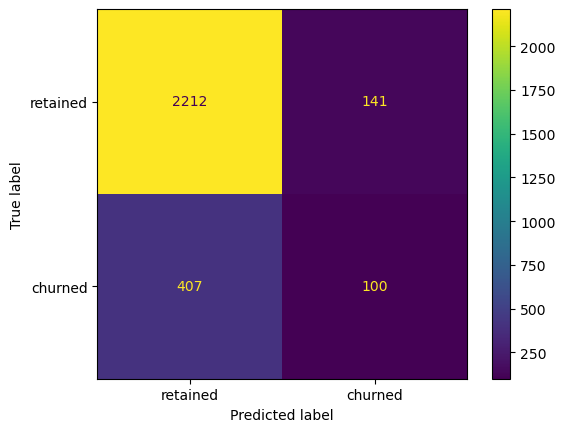

In [71]:
# Generate array of values for confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=['retained', 'churned'])
disp.plot();

The model predicted three times as many false negatives than it did false positives, and it correctly identified only 19.7% of the users who actually churned.

### **Task 14. Feature importance**

Using the `plot_importance` function to inspect the most important features of the final model.

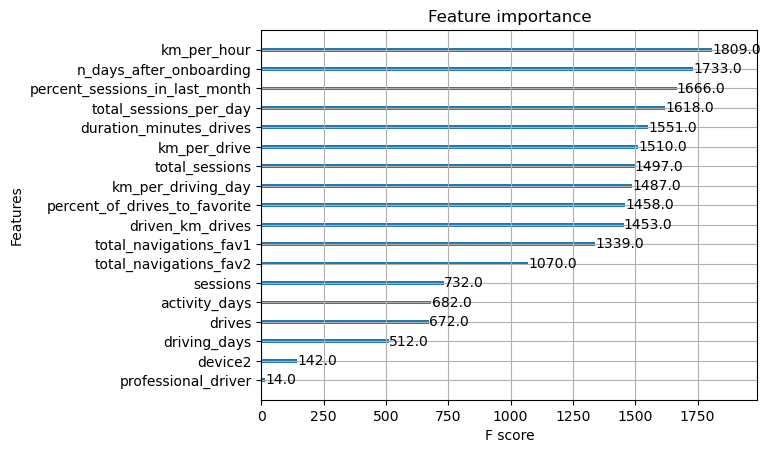

In [72]:
plot_importance(xgb_cv.best_estimator_);

The XGBoost model made more use of many of the features than did the logistic regression model from the previous task, which weighted a single feature (`activity_days`) very heavily in its final prediction.

If anything, this underscores the importance of feature engineering. Engineered features accounted for six of the top 10 features (and three of the top five). Feature engineering is often one of the best and easiest ways to boost model performance.

Also, the important features in one model might not be the same as the important features in another model. That's why we shouldn't discount features as unimportant without thoroughly examining them and understanding their relationship with the dependent variable, if possible. These discrepancies between features selected by models are typically caused by complex feature interactions.


### **Task 15. Conclusion**

Now that we've built and tested the machine learning models, the next step is to share our findings with the Waze leadership team. Considering the following questions as we prepare to write thr executive summary. Think about key points we may want to share with the team, and what information is most relevant to the user churn project.

**Questions:**

1. Would we recommend using this model for churn prediction? Why or why not?

> _It depends. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value._

2. What tradeoff was made by splitting the data into training, validation, and test sets as opposed to just training and test sets?

> _Splitting the data three ways means that there is less data available to train the model than splitting just two ways. However, performing model selection on a separate validation set enables testing of the champion model by itself on the test set, which gives a better estimate of future performance than splitting the data two ways and selecting a champion model by performance on the test data._

3. What is the benefit of using a logistic regression model over an ensemble of tree-based models (like random forest or XGBoost) for classification tasks?

> _Logistic regression models are easier to interpret. Because they assign coefficients to predictor variables, they reveal not only which features factored most heavily into their final predictions, but also the directionality of the weight. In other words, they tell you if each feature is positively or negatively correlated with the target in the model's final prediction._

4. What is the benefit of using an ensemble of tree-based models like random forest or XGBoost over a logistic regression model for classification tasks?

> _Tree-based model ensembles are often better predictors. If the most important thing is the predictive power of the model, then tree-based modeling will usually win out against logistic regression (but not always!). They also require much less data cleaning and require fewer assumptions about the underlying distributions of their predictor variables, so they're easier to work with._

5. What could we do to improve this model?

> _New features could be engineered to try to generate better predictive signal, as they often do if we have domain knowledge. In the case of this model, the engineered features made up over half of the top 10 most-predictive features used by the model. It could also be helpful to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._

6. What additional features would we like to have to help improve the model?

> _It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._



The following content demonstrates further steps that we might take to tailor our model to this use case.

#### **Identify an optimal decision threshold**

The default decision threshold for most implementations of classification algorithms&mdash;including scikit-learn's&mdash;is 0.5. This means that, in the case of the Waze models, if they predicted that a given user had a 50% probability or greater of churning, then that user was assigned a predicted value of `1`&mdash;the user was predicted to churn.

With imbalanced datasets where the response class is a minority, this threshold might not be ideal. We learned that a precision-recall curve can help to visualize the trade-off between our model's precision and recall.

Here's the precision-recall curve for the XGBoost champion model on the test data.

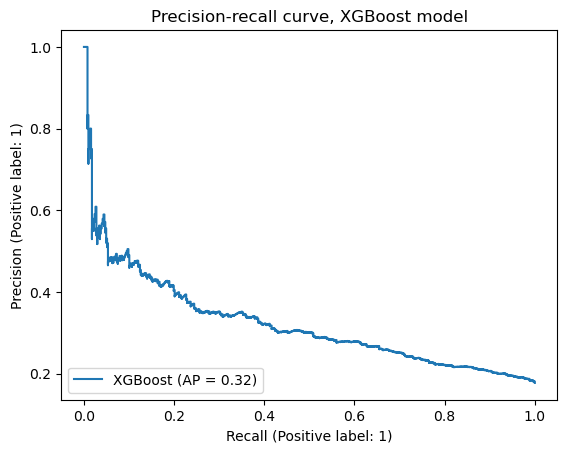

In [73]:
# Plot precision-recall curve
display = PrecisionRecallDisplay.from_estimator(
    xgb_cv.best_estimator_, X_test, y_test, name='XGBoost'
    )
plt.title('Precision-recall curve, XGBoost model');

As recall increases, precision decreases. But what if we determined that false positives aren't much of a problem? For example, in the case of this Waze project, a false positive could just mean that a user who will not actually churn gets an email and a banner notification on their phone. It's very low risk.

So, what if instead of using the default 0.5 decision threshold of the model, we used a lower threshold?

Here's an example where the threshold is set to 0.4:

In [74]:
# Get predicted probabilities on the test data
predicted_probabilities = xgb_cv.best_estimator_.predict_proba(X_test)
predicted_probabilities

array([[0.97590214, 0.02409787],
       [0.627488  , 0.37251198],
       [0.9972318 , 0.00276822],
       ...,
       [0.88422364, 0.11577634],
       [0.95692074, 0.04307923],
       [0.7587577 , 0.24124229]], dtype=float32)

The `predict_proba()` method returns a 2-D array of probabilities where each row represents a user. The first number in the row is the probability of belonging to the negative class, the second number in the row is the probability of belonging to the positive class. (Notice that the two numbers in each row are complimentary to each other and sum to one.)

We can generate new predictions based on this array of probabilities by changing the decision threshold for what is considered a positive response. For example, the following code converts the predicted probabilities to {0, 1} predictions with a threshold of 0.4. In other words, any users who have a value ≥ 0.4 in the second column will get assigned a prediction of `1`, indicating that they churned.

In [75]:
# Create a list of just the second column values (probability of target)
probs = [x[1] for x in predicted_probabilities]

# Create an array of new predictions that assigns a 1 to any value >= 0.4
new_preds = np.array([1 if x >= 0.4 else 0 for x in probs])
new_preds

array([0, 0, 0, ..., 0, 0, 0])

In [76]:
# Get evaluation metrics for when the threshold is 0.4
get_test_scores('XGB, threshold = 0.4', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.4",0.374214,0.234714,0.288485,0.794755


Compare these numbers with the results from earlier.

In [77]:
results

,model,precision,recall,F1,accuracy
0,RF cv,0.473061,0.130066,0.203811,0.820142
0,XGB cv,0.418953,0.177395,0.248703,0.810584
0,RF val,0.432624,0.120316,0.188272,0.816084
0,XGB val,0.401826,0.173570,0.242424,0.807692
0,XGB test,0.414938,0.197239,0.267380,0.808392


Recall and F1 score increased significantly, while precision and accuracy decreased marginally.

So, using the precision-recall curve as a guide, suppose we knew that you'd be satisfied if the model had a recall score of 0.5 and we were willing to accept the \~30% precision score that comes with it. In other words, we'd be happy if the model successfully identified half of the people who will actually churn, even if it means that when the model says someone will churn, it's only correct about 30% of the time.

What threshold will yield this result? Here's one way that uses a function to accomplish this.

In [78]:
def threshold_finder(y_test_data, probabilities, desired_recall):
    '''
    Find the decision threshold that most closely yields a desired recall score.

    Inputs:
        y_test_data: Array of true y values
        probabilities: The results of the `predict_proba()` model method
        desired_recall: The recall that you want the model to have

    Outputs:
        threshold: The decision threshold that most closely yields the desired recall
        recall: The exact recall score associated with `threshold`
    '''
    probs = [x[1] for x in probabilities]  # Isolate second column of `probabilities`
    thresholds = np.arange(0, 1, 0.001)    # Set a grid of 1,000 thresholds to test

    scores = []
    for threshold in thresholds:
        # Create a new array of {0, 1} predictions based on new threshold
        preds = np.array([1 if x >= threshold else 0 for x in probs])
        # Calculate recall score for that threshold
        recall = recall_score(y_test_data, preds)
        # Append the threshold and its corresponding recall score as a tuple to `scores`
        scores.append((threshold, recall))

    distances = []
    for idx, score in enumerate(scores):
        # Calculate how close each actual score is to the desired score
        distance = abs(score[1] - desired_recall)
        # Append the (index#, distance) tuple to `distances`
        distances.append((idx, distance))

    # Sort `distances` by the second value in each of its tuples (least to greatest)
    sorted_distances = sorted(distances, key=lambda x: x[1], reverse=False)
    # Identify the tuple with the actual recall closest to desired recall
    best = sorted_distances[0]
    # Isolate the index of the threshold with the closest recall score
    best_idx = best[0]
    # Retrieve the threshold and actual recall score closest to desired recall
    threshold, recall = scores[best_idx]

    return threshold, recall


Now, test the function to find the threshold that results in a recall score closest to 0.5.

In [79]:
# Get the predicted probabilities from the champion model
probabilities = xgb_cv.best_estimator_.predict_proba(X_test)

# Call the function
threshold_finder(y_test, probabilities, 0.5)

(0.127, 0.5009861932938856)

Setting a threshold of 0.124 will result in a recall of 0.503.

To verify, we can repeat the steps performed earlier to get the other evaluation metrics for when the model has a threshold of 0.127. Based on the precision-recall curve, a 0.5 recall score should have a precision of \~0.3.

In [80]:
# Create an array of new predictions that assigns a 1 to any value >= 0.124
probs = [x[1] for x in probabilities]
new_preds = np.array([1 if x >= 0.124 else 0 for x in probs])

# Get evaluation metrics for when the threshold is 0.124
get_test_scores('XGB, threshold = 0.124', new_preds, y_test)

,model,precision,recall,F1,accuracy
0,"XGB, threshold = 0.124",0.298144,0.506903,0.375457,0.701049


It worked! Hopefully now we know that changing the decision threshold is another tool that can help us achieve useful results from the model.